<a href="https://colab.research.google.com/github/SamuelMiller413/Deep-Learning-Course/blob/main/DL_12_Intro_to_transfer_learning_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install -Uqq fastai gradio
!apt-get install tree

In [ ]:
from fastai.vision.all import *
from fastai import *
from torch import nn, optim
import torch

from IPython.display import display, YouTubeVideo

In [ ]:
SIZE = {'width':1000, 'height': 600}

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
list(path.ls())

[Path('/root/.fastai/data/oxford-iiit-pet/annotations'),
 Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [ ]:
!tree {str(path/'images')} | grep .jpg | shuf -n 10

├── pomeranian_160.jpg
├── Bombay_50.jpg
├── Ragdoll_107.jpg
├── shiba_inu_47.jpg
├── basset_hound_83.jpg
├── great_pyrenees_65.jpg
├── yorkshire_terrier_107.jpg
├── american_bulldog_218.jpg
├── japanese_chin_186.jpg
├── beagle_77.jpg


In [ ]:
def label_func(filename):
    return '_'.join(filename.split('_')[:-1])

In [ ]:
dls = ImageDataLoaders.from_name_func(
    path=path, 
    fnames=get_image_files(path/'images'), 
    label_func=label_func, 
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
)

In [ ]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

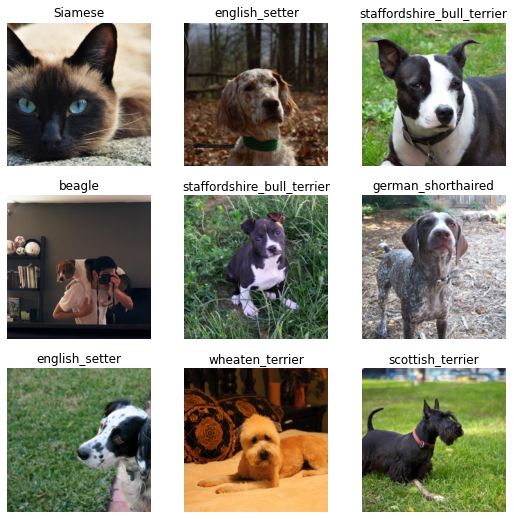

In [ ]:
dls.show_batch()

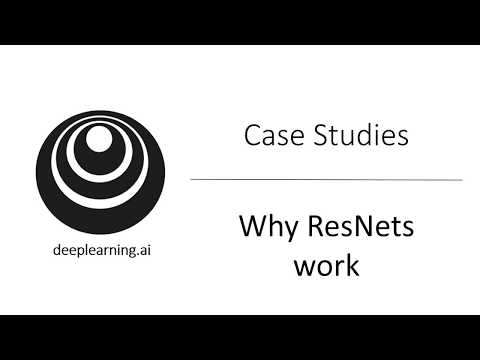

In [ ]:
vid = YouTubeVideo('RYth6EbBUqM', **SIZE)
display(vid)

In [ ]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    models.resnet34, # Specify the architechture you want to use
    pretrained=False, # Tell it NOT to fetch the ImageNet weights
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
print(f"""
There are {learn.dls.c} categories.
If we guessed randomly, we would have about a {100. * 1/learn.dls.c:.02f}% chance of guessing correctly.
""")


There are 37 categories.
If we guessed randomly, we would have about a 2.70% chance of guessing correctly.



In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,4.651857,19.287863,0.035859,0.964141,00:58
1,4.230425,3.706223,0.062923,0.937077,00:52
2,3.851058,3.129208,0.144114,0.855886,00:52
3,3.658750,4.298142,0.166441,0.833559,00:52
4,3.391190,3.125417,0.191475,0.808525,00:53


In [ ]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    models.resnet34, # Specify the architechture you want to use
    pretrained=True, # Tell it to fetch the ImageNet weights
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [ ]:
LR = 1e-3

In [ ]:
# Train the classifier head
learn.fit_one_cycle(1, LR)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.224824,0.335237,0.889716,0.110284,00:48


In [ ]:
# Unfreeze the backbone
learn.unfreeze()

In [ ]:
# Trainin everything together
learn.fit_one_cycle(5, lr_max=slice(LR/10, LR))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.576673,0.510767,0.832882,0.167118,00:52
1,0.517488,0.452067,0.858593,0.141407,00:52
2,0.320618,0.412590,0.891069,0.108931,00:51
3,0.145510,0.270787,0.923545,0.076455,00:51
4,0.066292,0.229831,0.932341,0.067659,00:52


In [ ]:
cbs = [
    EarlyStoppingCallback(patience=3)
]

learn = cnn_learner( # Instantiate a learner object
    dls, # Pass the dataloaders
    resnet34, # Specify the architechture you want to use
    pretrained=True, # Tell it to fetch the ImageNet weights
    # loss_func=nn.CrossEntropyLoss(), # Pass the loss function
    cbs=cbs, # Pass the callbacks
    metrics=[accuracy, error_rate] # Pass the metrics you want to see
)

In [ ]:
learn.fine_tune(5, base_lr=LR)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.955422,0.362955,0.883627,0.116373,00:49


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.543647,0.246371,0.916779,0.083221,00:52
1,0.353519,0.221456,0.926928,0.073072,00:52
2,0.200499,0.208312,0.937077,0.062923,00:52
3,0.117633,0.191441,0.941137,0.058863,00:51
4,0.089112,0.187295,0.947226,0.052774,00:53


In [ ]:
import gradio as gr

TensorCategory(16)


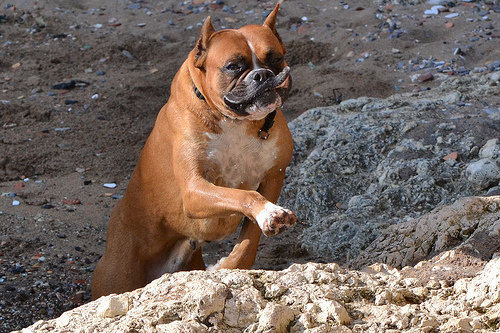

In [ ]:
# grab one image from our training dataset
img, cat = dls.train_ds[0]
print(cat)
img

In [ ]:
breed, cat_id, logits = learn.predict(img)
print(breed, cat_id, sep='\n')
print(logits.sum())

boxer
TensorBase(16)
TensorBase(1.)


In [ ]:
def recognize_pet(img):
    breed, cat_id, logits = learn.predict(img)
    proba = float(logits.softmax(dim=0).max())
    return f"""
    Breed: {breed},
    Probability: {proba:.04f}
    """

print(recognize_pet(img))


    Breed: boxer,
    Probability: 0.0702
    


# Exercise 12.1

Run the block of code below.
Find a few images of pets to upload and observe the inferences made by the model.
Do they work decently well?

<!-- startquestion -->

In [ ]:
learn.dls.vocab


['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [ ]:
gr.Interface(recognize_pet, inputs=gr.inputs.Image(source='upload'), outputs=gr.outputs.Label()).launch(inline=True, debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9e73ee1bf9cea57d.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f570458d9d0>,
 'http://127.0.0.1:7861/',
 'https://9e73ee1bf9cea57d.gradio.app')

In [ ]:
def conv_block(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(0.2)
    )

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # If the channels or output shape are different, 
        # we need a projection so the channels match
        self.projection = True if in_channels != out_channels or stride > 1 else False
        # The projection is just a 1x1 convolutional layer that changes
        # the number of channels to match out_channels.
        if self.projection:
            self.proj = nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=1, 
                padding=0,
                stride=stride # If the shape changes, this is one way to downsample spatially.
            )

        # Now just add the easy part of the network
        self.conv1 = conv_block(in_channels, out_channels, stride)
        self.conv2 = conv_block(out_channels, out_channels)
        self.final_act = nn.PReLU()

    def forward(self, x):
        # Declare the identity
        identity = x
        # but if we need to do the projection, project x 
        # into a different number of channels.
        if self.projection:
            identity = self.proj(x)
        # Pass the original x through the conv network
        acts = self.conv2(self.conv1(x))
        # Return the identity + the activations of the conv network
        return self.final_act(identity + acts)

In [ ]:
fake_batch = torch.randn(2, 32, 28, 28)

In [ ]:
res = ResidualConvBlock(32, 32)
res

ResidualConvBlock(
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (final_act): PReLU(num_parameters=1)
)

In [ ]:
res(fake_batch).shape

torch.Size([2, 32, 28, 28])

In [ ]:
res = ResidualConvBlock(32, 64)
res

ResidualConvBlock(
  (proj): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (final_act): PReLU(num_parameters=1)
)

In [ ]:
res(fake_batch).shape

torch.Size([2, 64, 28, 28])

In [ ]:
res = ResidualConvBlock(32, 64, 2)
res

ResidualConvBlock(
  (proj): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
  (conv1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (final_act): PReLU(num_parameters=1)
)

In [ ]:
res(fake_batch).shape

torch.Size([2, 64, 14, 14])

In [ ]:
def build_model(*args, **kwargs):
    model = nn.Sequential(
        nn.BatchNorm2d(3),
        ResidualConvBlock(3, 16),
        ResidualConvBlock(16,16),
        ResidualConvBlock(16,32,2),
        ResidualConvBlock(32, 64),
        nn.AdaptiveMaxPool2d(1),
        nn.Flatten(),
        nn.Linear(64, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 37)
    )
    return model

In [ ]:
learn = cnn_learner(dls, build_model, pretrained=False, metrics=[accuracy, error_rate])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
learn.fit_one_cycle(20, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,5.005449,4.672110,0.030447,0.969553,00:59
1,4.708154,4.091148,0.046008,0.953992,00:58
2,4.471907,3.926656,0.039919,0.960081,00:59
3,4.278913,3.857754,0.067659,0.932341,00:58
4,4.155679,3.766767,0.068336,0.931664,00:58
5,3.986710,3.648060,0.071042,0.928958,00:59
6,3.851769,3.523216,0.073072,0.926928,00:58
7,3.722569,3.464688,0.091340,0.908660,00:58
8,3.628783,3.543725,0.096752,0.903248,00:59
9,3.501576,3.512695,0.099459,0.900541,00:59
